## simple neural network to for roasting coffee

In [4]:
import numpy as np
import matplotlib.pyplot as plt
# plt.style.use('./deeplearning.mplstyle')
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

In [35]:
#helper functions
# from lab_utils_common import dlc
# from lab_coffee_utils import  plt_prob, plt_layer, plt_network, plt_output_unit
#load_coffee_data , plt_roast,
from tensorflow.keras.activations import sigmoid
import matplotlib.colors as colors
from matplotlib import cm

dlc = dict(dlblue = '#0096ff', dlorange = '#FF9300', dldarkred='#C00000', dlmagenta='#FF40FF', dlpurple='#7030A0', dldarkblue =  '#0D5BDC')

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    """ truncates color map """
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def plt_roast(X,Y):
    Y = Y.reshape(-1,)
    colormap = np.array(['r', 'b'])
    fig, ax = plt.subplots(1,1,)
    ax.scatter(X[Y==1,0],X[Y==1,1], s=70, marker='x', c='red', label="Good Roast" )
    ax.scatter(X[Y==0,0],X[Y==0,1], s=100, marker='o', facecolors='none', edgecolors=dlc["dldarkblue"],linewidth=1,  label="Bad Roast")
    
    tr = np.linspace(175,260,50)
    
    ax.plot(tr, (-3/85) * tr + 21, color=dlc["dlpurple"],linewidth=1)
    
    ax.axhline(y=12,color=dlc["dlpurple"],linewidth=1)
    ax.axvline(x=175,color=dlc["dlpurple"],linewidth=1)
    ax.set_title(f"Coffee Roasting", size=16)
    ax.set_xlabel("Temperature \n(Celsius)",size=12)
    ax.set_ylabel("Duration \n(minutes)",size=12)
    ax.legend(loc='upper right')
    plt.show()

def plt_prob(ax,fwb):
    """ plots a decision boundary but include shading to indicate the probability """
    #setup useful ranges and common linspaces
    x0_space  = np.linspace(150, 285 , 40)  # temperature
    x1_space  = np.linspace(11.5, 15.5 , 40) # duration
    print(x0_space.shape)

    # get probability for x0,x1 ranges
    tmp_x0,tmp_x1 = np.meshgrid(x0_space,x1_space)
    
    print(tmp_x0.shape)

    # creating a 2D array of the input space, then predicting the probability for each point in the input space using only one activation unit at the time
    z = np.zeros_like(tmp_x0)
    for i in range(tmp_x0.shape[0]):
        for j in range(tmp_x1.shape[1]):
            x = np.array([[tmp_x0[i,j],tmp_x1[i,j]]])
            z[i,j] = fwb(x)


    cmap = plt.get_cmap('Blues')
    new_cmap = truncate_colormap(cmap, 0.0, 0.5)
    pcm = ax.pcolormesh(tmp_x0, tmp_x1, z, norm=cm.colors.Normalize(vmin=0, vmax=1),cmap=new_cmap, shading='nearest', alpha = 0.9)
    ax.figure.colorbar(pcm, ax=ax)

def plt_layer(X,Y,W1,b1,norm_l):
    Y = Y.reshape(-1,)
    fig,ax = plt.subplots(1,W1.shape[1], figsize=(16,4))
    for i in range(W1.shape[1]):
        layerf= lambda x : sigmoid(np.dot(norm_l(x),W1[:,i]) + b1[i])
        
        plt_prob(ax[i], layerf)
        
        ax[i].scatter(X[Y==1,0],X[Y==1,1], s=70, marker='x', c='red', label="Good Roast" )
        ax[i].scatter(X[Y==0,0],X[Y==0,1], s=100, marker='o', facecolors='none', edgecolors=dlc["dldarkblue"],linewidth=1,  label="Bad Roast")
        
        tr = np.linspace(175,260,50)
        ax[i].plot(tr, (-3/85) * tr + 21, color=dlc["dlpurple"],linewidth=2)
        ax[i].axhline(y= 12, color=dlc["dlpurple"], linewidth=2)
        ax[i].axvline(x=175, color=dlc["dlpurple"], linewidth=2)
        ax[i].set_title(f"Layer 1, unit {i}")
        ax[i].set_xlabel("Temperature \n(Celsius)",size=12)
    ax[0].set_ylabel("Duration \n(minutes)",size=12)
    plt.show()

def plt_output_unit(W,b):
    """ plots a single unit function with 3 inputs """
    steps = 10
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    x_ = np.linspace(0., 1., steps)
    y_ = np.linspace(0., 1., steps)
    z_ = np.linspace(0., 1., steps)
    x, y, z = np.meshgrid(x_, y_, z_, indexing='ij')
    d = np.zeros((steps,steps,steps))
    cmap = plt.get_cmap('Blues')
    for i in range(steps):
        for j in range(steps):
            for k in range(steps):
                v = np.array([x[i,j,k],y[i,j,k],z[i,j,k]])
                d[i,j,k] = tf.keras.activations.sigmoid(np.dot(v,W[:,0])+b).numpy()
    pcm = ax.scatter(x, y, z, c=d, cmap=cmap, alpha = 1 )
    ax.set_xlabel("unit 0"); 
    ax.set_ylabel("unit 1"); 
    ax.set_zlabel("unit 2"); 
    ax.view_init(30, -120)
    ax.figure.colorbar(pcm, ax=ax)
    ax.set_title(f"Layer 2, output unit")

    plt.show()


Create the dataset

(200, 2) (200, 1)


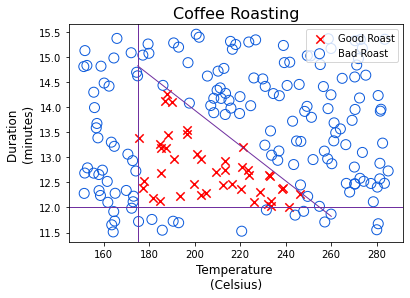

In [10]:
rng = np.random.default_rng(2)

# coffee roasted data has two features: temperature and time
X = rng.random(400).reshape(-1,2) # converts the 400 random numbers into a 200x2 matrix

X[:,0] = X[:,0] * (285-150) + 150  # create the temp feature: 350-500 F (175-260 C) is best 
X[:,1] = X[:,1] * 4 + 11.5         # create the time feature: 12-15 min is best 

Y = np.zeros(len(X)) # target is just a single value: 0 or 1

i=0
for t,d in X:
    y = -3/(260-175)*t + 21
    if (t > 175 and t < 260 and d > 12 and d < 15 and d<=y ):
        Y[i] = 1
    else:
        Y[i] = 0
    i += 1

Y=Y.reshape(-1,1)

print(X.shape, Y.shape)
plt_roast(X,Y)

### Normalize Data
Normalizing the feature, for quick back propagation process (Gradient descent).

- create a "Normalization Layer". Note, as applied here, this is not a layer in your model.
- 'adapt' the data. This learns the mean and variance of the data set and saves the values internally.
- normalize the data.
It is important to apply normalization to any future data that utilizes the learned model.

In [12]:
print(f"Temperature Max, Min pre normalization: {np.max(X[:,0]):0.2f}, {np.min(X[:,0]):0.2f}")
print(f"Duration    Max, Min pre normalization: {np.max(X[:,1]):0.2f}, {np.min(X[:,1]):0.2f}")

norm_l = tf.keras.layers.Normalization(axis=-1)
norm_l.adapt(X)  # learns mean, variance
Xn = norm_l(X)

print(f"Temperature Max, Min post normalization: {np.max(Xn[:,0]):0.2f}, {np.min(Xn[:,0]):0.2f}")
print(f"Duration    Max, Min post normalization: {np.max(Xn[:,1]):0.2f}, {np.min(Xn[:,1]):0.2f}")

# Tile/copy our data to increase the training set size and reduce the number of training epochs.
Xt = np.tile(Xn,(1000,1))
Yt= np.tile(Y,(1000,1))   
print(Xt.shape, Yt.shape)   

Temperature Max, Min pre normalization: 284.99, 151.32
Duration    Max, Min pre normalization: 15.45, 11.51
Temperature Max, Min post normalization: 1.66, -1.69
Duration    Max, Min post normalization: 1.79, -1.70
(200000, 2) (200000, 1)


Note 1: The tf.keras.Input(shape=(2,)), specifies the expected shape of the input. This allows Tensorflow to size the weights and bias parameters at this point. This is useful when exploring Tensorflow models. This statement can be omitted in practice and Tensorflow will size the network parameters when the input data is specified in the model.fit statement.

Note 2: Including the sigmoid activation in the final layer is not considered best practice. It would instead be accounted for in the loss which improves numerical stability. 

There are three steps for any ML model:
- step 1: Define the model
- step 2: define the loss+cost function and the optimizer
- step 3: fit the model to the data/train the model

In [14]:
# neural network model

tf.random.set_seed(1234)  # applied to achieve consistent results

#step 1: Define the model
model = Sequential(
    [
        tf.keras.Input(shape=(2,)),
        Dense(3, activation='sigmoid', name = 'layer1'),
        Dense(1, activation='sigmoid', name = 'layer2')
     ]
)
model.summary() # for layer 1, there are 9 parameters (6 weights and 3 biases), for layer 2, there are 4 parameters (3 weights and 1 bias)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 3)                 9         
                                                                 
 layer2 (Dense)              (None, 1)                 4         
                                                                 
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________


In [15]:
# intiailizion the weights and biases
W1, b1 = model.get_layer("layer1").get_weights()
W2, b2 = model.get_layer("layer2").get_weights()
print(f"W1{W1.shape}:\n", W1, f"\nb1{b1.shape}:", b1)
print(f"W2{W2.shape}:\n", W2, f"\nb2{b2.shape}:", b2)

W1(2, 3):
 [[-0.39590627 -0.37368166 -0.08920288]
 [ 0.03287923  0.9157543  -1.0099847 ]] 
b1(3,): [0. 0. 0.]
W2(3, 1):
 [[-0.60220814]
 [-0.1437999 ]
 [-0.12881255]] 
b2(1,): [0.]


In [17]:
# The model.compile statement defines a loss function and specifies a compile optimization.

#step 2: define the loss+cost function and the optimizer
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(), # define the loss function
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01), # define the optimizer
)

# step 3: fit the model to the data/train the model
# The model.fit statement runs gradient descent and fits the weights to the data.
# For efficiency, the training data set is broken into 'batches'. The default size of a batch in Tensorflow is 32. There are 200000 examples in our expanded data set or 6250 batches. 
# default batch size is 32, so 6250 batches
model.fit(
    Xt,Yt,            
    epochs=10, # total number of iterations/steps of gradient descent
)

# updated weights and biases
W1, b1 = model.get_layer("layer1").get_weights()
W2, b2 = model.get_layer("layer2").get_weights()
print(f"W1{W1.shape}:\n", W1, f"\nb1{b1.shape}:", b1)
print(f"W2{W2.shape}:\n", W2, f"\nb2{b2.shape}:", b2)

Epoch 1/10
6250/6250 [==============================] - 6s 966us/step - loss: 0.0015
Epoch 2/10
6250/6250 [==============================] - 6s 910us/step - loss: 0.0011
Epoch 3/10
6250/6250 [==============================] - 6s 893us/step - loss: 8.8431e-04
Epoch 4/10
6250/6250 [==============================] - 5s 875us/step - loss: 6.8630e-04
Epoch 5/10
6250/6250 [==============================] - 5s 867us/step - loss: 5.3987e-04
Epoch 6/10
6250/6250 [==============================] - 6s 894us/step - loss: 4.2739e-04
Epoch 7/10
6250/6250 [==============================] - 6s 880us/step - loss: 3.3863e-04
Epoch 8/10
6250/6250 [==============================] - 6s 956us/step - loss: 2.8194e-04
Epoch 9/10
6250/6250 [==============================] - 5s 845us/step - loss: 2.2295e-04
Epoch 10/10
6250/6250 [==============================] - 6s 898us/step - loss: 2.0589e-04
W1(2, 3):
 [[-11.911558    16.871006    -0.17680138]
 [ -0.28182775  13.9910965   -9.681726  ]] 
b1(3,): [-12.794752 

In [ ]:
#to manually set the weights and biases
W1 = np.array([
    [-8.94,  0.29, 12.89],
    [-0.17, -7.34, 10.79]] )
b1 = np.array([-9.87, -9.28,  1.01])
W2 = np.array([
    [-31.38],
    [-27.86],
    [-32.79]])
b2 = np.array([15.54])
#model.get_layer("layer1").set_weights([W1,b1])
#model.get_layer("layer2").set_weights([W2,b2])

In [20]:
X_test = np.array([
    [200,13.9],  # postive example
    [200,17]])   # negative example
X_testn = norm_l(X_test)
predictions = model.predict(X_testn)
print("predictions = \n", predictions)

yhat = (predictions >= 0.5).astype(int)
print(f"decisions = \n{yhat}")

1/1 [==============================] - 0s 17ms/step
predictions = 
 [[9.9951315e-01]
 [4.8088804e-09]]
decisions = 
[[1]
 [0]]


(40,)
(40, 40)
(40,)
(40, 40)
(40,)
(40, 40)


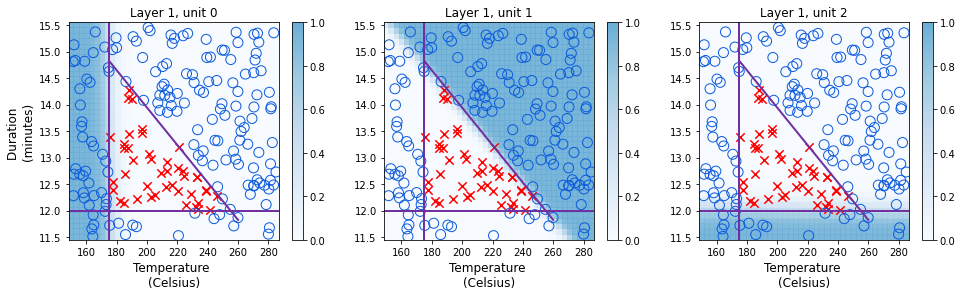

In [34]:
plt_layer(X,Y.reshape(-1,),W1,b1,norm_l)

The above plot shows that each activation unit in layer one, learns one area in the code. 

The function plot of the final layer is a bit more difficult to visualize. It's inputs are the output of the first layer. We know that the first layer uses sigmoids so their output range is between zero and one. We can create a 3-D plot that calculates the output for all possible combinations of the three inputs. This is shown below. Above, high output values correspond to 'bad roast' area's. Below, the maximum output is in area's where the three inputs are small values corresponding to 'good roast' area's.

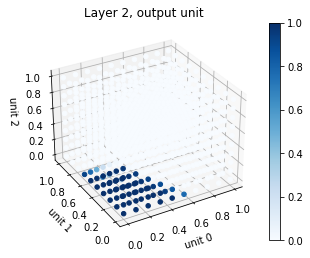

In [36]:
plt_output_unit(W2,b2)